# Introduction to kernel methods
---

In [1]:
import numpy as np
import pandas as pd
from itertools import combinations_with_replacement, product

## Build a simple dataset

In [2]:
data = {'Molecule': ['H2O', 'HCN', 'CO2', 'NH3', 'C2H2', 'CH4'], 
        'num_atoms': [3, 3, 3, 4, 4, 5], 
        'num_carbons': [0, 1, 1, 0, 2, 1], 
        'num_hydrogens': [2, 1, 0, 3, 2, 4]}
df = pd.DataFrame(data)
df

,Molecule,num_atoms,num_carbons,num_hydrogens
0,H2O,3,0,2
1,HCN,3,1,1
2,CO2,3,1,0
3,NH3,4,0,3
4,C2H2,4,2,2
5,CH4,5,1,4


## Compute the dot products

In [3]:
# STEP 1: Create a list with all possible combinations of pairs of molecules
idx_pairs = list(combinations_with_replacement(df.index, 2))

# STEP 2: Create an empty NxN matrix to store the dot products
n_samples = df.shape[0]
K = np.full((n_samples, n_samples), np.nan)

# STEP 3: Select only the feature vectors from the dataset
X = df.drop(['Molecule'], axis=1).values

# STEP 4: Iterate over the list of pairs and store the dot products in K
for i,j in idx_pairs:
  K[j,i] = K[i,j] = np.dot(X[i],X[j].T)/(np.linalg.norm(X[i])*np.linalg.norm(X[j]))

In [4]:
print("Cosine similarity kernel:")
print("=========================\n")
print(K)

Cosine similarity kernel:

[[1.         0.91986621 0.78935222 0.99846035 0.90582163 0.98430913]
 [0.91986621 1.         0.95346259 0.90453403 0.98473193 0.93048421]
 [0.78935222 0.95346259 1.         0.75894664 0.90369611 0.78072006]
 [0.99846035 0.90453403 0.75894664 1.         0.89814624 0.98754144]
 [0.90582163 0.98473193 0.90369611 0.89814624 1.         0.94491118]
 [0.98430913 0.93048421 0.78072006 0.98754144 0.94491118 1.        ]]


## Visualize the similarity matrix 

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

%matplotlib inline
plt.style.use('seaborn-white')

In [6]:
df_kernel = pd.DataFrame(K, index=df.Molecule.to_list(), columns=df.Molecule.to_list())
df_kernel = df_kernel.round(3)
df_kernel

,H2O,HCN,CO2,NH3,C2H2,CH4
H2O,1.000,0.920,0.789,0.998,0.906,0.984
HCN,0.920,1.000,0.953,0.905,0.985,0.930
CO2,0.789,0.953,1.000,0.759,0.904,0.781
NH3,0.998,0.905,0.759,1.000,0.898,0.988
C2H2,0.906,0.985,0.904,0.898,1.000,0.945
CH4,0.984,0.930,0.781,0.988,0.945,1.000


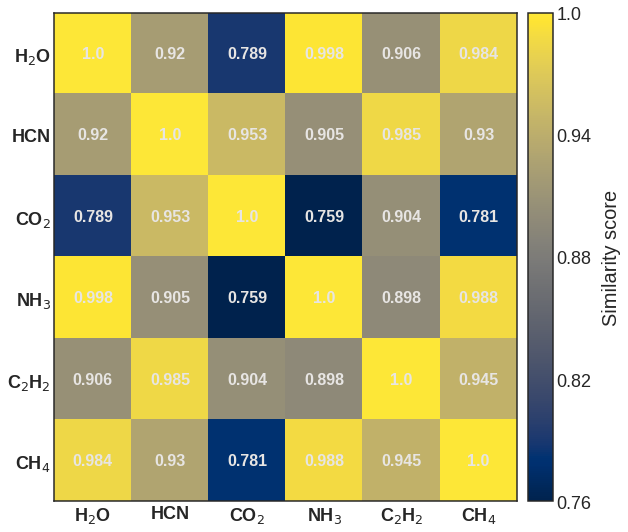

In [7]:
plt.rcParams['axes.linewidth'] = 1.5
plt.figure(figsize=(8.9,7.5))
k_min = df_kernel.values.min()
k_max = df_kernel.values.max()
plt.imshow(df_kernel, cmap='cividis', vmin=k_min, vmax=k_max, aspect='auto')
#molecules = df_kernel.index.to_list()
molecules = ['H$_2$O', 'HCN', 'CO$_2$', 'NH$_3$', 
             'C$_2$H$_2$','CH$_4$']
ticks = [i for i in range(len(molecules))]
plt.yticks(ticks, molecules, fontsize=18, fontweight="bold")
plt.xticks(ticks, molecules, fontsize=18, fontweight="bold")
cb = plt.colorbar(pad=0.02)
interval = (k_max - k_min) / 4
cbar_ticks = np.arange(k_min, k_max+interval, interval)
cb.set_ticks(cbar_ticks)
cb.ax.set_yticklabels(np.around(cbar_ticks, decimals=2),fontsize=18)
cb.set_label("Similarity score", fontsize=20, labelpad=11)

for i in range(len(df_kernel.index)):
    for j in range(len(df_kernel.columns)):
      text = plt.text(j, i, s=df_kernel.iloc[i,j], ha="center", 
                      va="center", fontsize=16, fontweight="bold",
                      color="#E7E5E3")

plt.tight_layout()
#plt.savefig('kernel_matrix.png', dpi=600)
plt.show()

In [8]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

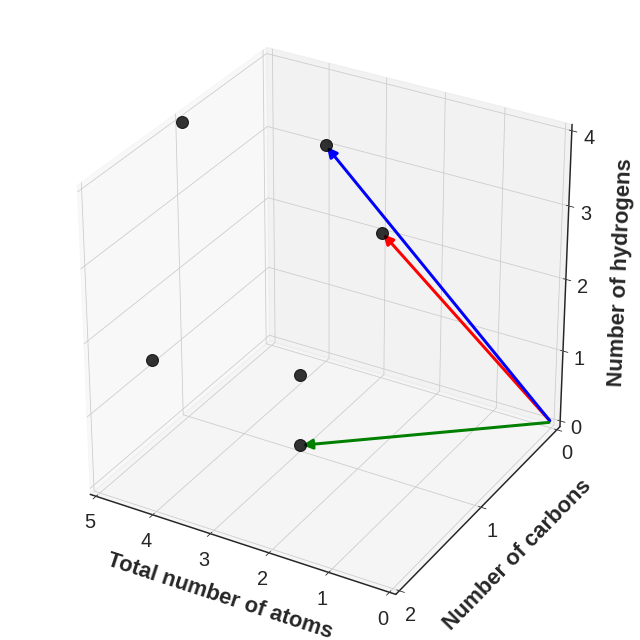

In [9]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')

ax.plot(df.num_atoms, df.num_carbons, df.num_hydrogens, 'o', markersize=12, color='k', alpha=0.8)
ax.set_zlim(0,4)
ax.set_zticks(np.arange(0,4.01,1))
ax.set_ylim(2,0)
ax.set_yticks(np.arange(0.0,2.1,1))
ax.set_xlim(5,0)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Total number of atoms', fontsize=22, fontweight='bold', labelpad=15)
ax.set_ylabel('Number of carbons', fontsize=22, fontweight='bold', labelpad=18)
ax.set_zlabel('Number of hydrogens', fontsize=22, fontweight='bold', labelpad=18)

vref = [0,0,0]

h2o = df[df['Molecule'] == 'H2O'].drop(['Molecule'], axis=1).values
h2o = h2o.flatten()
arr_h2o = Arrow3D([vref[0], h2o[0]], [vref[1], h2o[1]], 
                  [vref[2], h2o[2]], mutation_scale=20, 
                  lw=3, arrowstyle="-|>", color="r")
ax.add_artist(arr_h2o)

nh3 = df[df['Molecule'] == 'NH3'].drop(['Molecule'], axis=1).values
nh3 = nh3.flatten()
arr_nh3 = Arrow3D([vref[0], nh3[0]], [vref[1], nh3[1]], 
                  [vref[2], nh3[2]], mutation_scale=20, 
                  lw=3, arrowstyle="-|>", color="b")
ax.add_artist(arr_nh3)

co2 = df[df['Molecule'] == 'CO2'].drop(['Molecule'], axis=1).values
co2 = co2.flatten()
arr_co2 = Arrow3D([vref[0], co2[0]], [vref[1], co2[1]], 
                  [vref[2], co2[2]], mutation_scale=20, 
                  lw=3, arrowstyle="-|>", color="g")
ax.add_artist(arr_co2)

plt.tight_layout()
plt.draw()
#plt.savefig('molecules_3drep.png', dpi=600)
plt.show()

## Using kernels in ML models

Let's consider the formaldehyde molecule (CH2O) as the test point to evaluate the generalization performance of the ML models.

In [10]:
test_point = {'Molecule': ['CH2O'], 
              'num_atoms': [4], 
              'num_carbons': [1], 
              'num_hydrogens': 2}
df_test = pd.DataFrame(test_point)
df_test

,Molecule,num_atoms,num_carbons,num_hydrogens
0,CH2O,4,1,2


### **Classification with SVC**

In [11]:
df['has_dipole'] = [1,1,-1,1,-1,-1]
df

,Molecule,num_atoms,num_carbons,num_hydrogens,has_dipole
0,H2O,3,0,2,1
1,HCN,3,1,1,1
2,CO2,3,1,0,-1
3,NH3,4,0,3,1
4,C2H2,4,2,2,-1
5,CH4,5,1,4,-1


Here we will use a support vector classifier from scikit-learn library to train the model on six different molecules, and then use the trained model to predict if the new molecule CH$_2$O has a dipole moment or not.

In [12]:
from sklearn.svm import SVC

X_train = df.drop(['Molecule', 'has_dipole'], axis=1).values
y_train = df['has_dipole'].values

clf = SVC(C=2, kernel='precomputed', probability=True)
clf.fit(K, y_train)

SVC(C=2, kernel='precomputed', probability=True)

In [13]:
X_test = df_test.drop(['Molecule'], axis=1).values
K_test = np.full((1,K.shape[0]), np.nan)
for i, xi in enumerate(X_train):
  K_test[:,i] = np.dot(X_test,xi.T)/(np.linalg.norm(X_test)*np.linalg.norm(xi))

# The y_test variable contains the model prediction, either -1 or 1.
y_test = clf.predict(K_test)

In [14]:
print("Final classification:")
print("-" * 21 + "\n")
dipole_property = {1: 'polar', -1: 'non-polar'}
print(f"The molecule {df_test['Molecule'].values[0]} is {dipole_property.get(y_test[0])}.")  

Final classification:
---------------------

The molecule CH2O is polar.


### **Regression with KRR**

In [15]:
# Dipole data was taken from https://cccbdb.nist.gov/
# with the theory level CCSD=Full/aug-ccpVTZ
df['dipole'] = [1.863,2.995,0.000,1.522,0.000,0.000]
df

,Molecule,num_atoms,num_carbons,num_hydrogens,has_dipole,dipole
0,H2O,3,0,2,1,1.863
1,HCN,3,1,1,1,2.995
2,CO2,3,1,0,-1,0.000
3,NH3,4,0,3,1,1.522
4,C2H2,4,2,2,-1,0.000
5,CH4,5,1,4,-1,0.000


In [16]:
from sklearn.kernel_ridge import KernelRidge

krr = KernelRidge(alpha=0.2,kernel='precomputed')
krr.fit(K,df['dipole'].values)

KernelRidge(alpha=0.2, kernel='precomputed')

In [17]:
y_true = 2.429
y_pred = krr.predict(K_test)
print("Model prediction:")
print("-" * 18)
print(f"KRR dipole = {y_pred[0]: .3f} Debye")
print("             ")
print(f"True dipole = {y_true: .3f} Debye")

Model prediction:
------------------
KRR dipole =  1.066 Debye
             
True dipole =  2.429 Debye


We can also compute the KRR model prediction for the test molecule explicitly by using the definition $f(x') = \sum_{i=1}^{6}\alpha_iK(x',x_i)$ (see equation 8 in the book chapter). To do that, we will first collect in a single table all the $\alpha_i$ coefficients obained after training the model together with the corresponding kernel evaluations between the test and training points.

In [18]:
krr_results = df[['Molecule']].copy()
krr_results['K(xi,x_test)'] = K_test.flatten()
krr_results['Coef'] = krr.dual_coef_
krr_results

,Molecule,"K(xi,x_test)",Coef
0,H2O,0.968364,3.025304
1,HCN,0.986928,10.146302
2,CO2,0.897085,-4.257733
3,NH3,0.960159,1.392524
4,C2H2,0.979958,-4.146281
5,CH4,0.976481,-5.460015


Note that, in the table above, the HCN molecule of the training set shows the highest "similarity score" with the test molecule CH$_2$O according to our cosine similarity kernel, and it is also the one contributing most (largest coefficient) to the model prediction.

Finally, the model prediction can be then obtained by summing up the product of the optimized coefficients with the respective kernel evaluations as shown below:

In [19]:
krr_dipole = np.sum(krr_results['K(xi,x_test)']*krr_results['Coef'])
print(f"KRR dipole = {krr_dipole: .3f} Debye")

KRR dipole =  1.066 Debye
